In [1]:
using Revise
# using InvariantDA
using HierarchicalDA
using LinearAlgebra
using OrdinaryDiffEq
using Trixi
using FFTW
using DifferentialEquations
using FastGaussQuadrature
using SpecialFunctions
using SparseArrays

Precompiling HierarchicalDA
  ✓ HierarchicalDA
  1 dependency successfully precompiled in 8 seconds. 498 already precompiled.


In [2]:
using CairoMakie
using LaTeXStrings
# using Plots

In [3]:
advection_velocity = 1.0
equations = LinearScalarAdvectionEquation1D(advection_velocity)

###############################################################################
#  setup the GSBP DG discretization that uses the Gauss operators from Chan et al.

surface_flux = FluxLaxFriedrichs()
# surface_flux = flux_lax_friedrichs

# volume_integral = VolumeIntegralShockCapturingHG(indicator_sc;
#                                                  volume_flux_dg = surface_flux,
#                                                  volume_flux_fv = surface_flux)
dg = DGMulti(polydeg = 3,
             element_type = Line(),
             approximation_type = GaussSBP(),
             surface_integral = SurfaceIntegralWeakForm(surface_flux),
             volume_integral = VolumeIntegralWeakForm())

###############################################################################
#  setup the 1D mesh

cells_per_dimension = (32,)
mesh = DGMultiMesh(dg, cells_per_dimension,
                   coordinates_min = (-1.0,), coordinates_max = (1.0,),
                   periodicity = true)

###############################################################################
#  setup the semidiscretization and ODE problem

semi = SemidiscretizationHyperbolic(mesh,
                                    equations,
                                    initial_condition_convergence_test,
                                    dg)

tspan = (0.0, 2.0)
ode = semidiscretize(semi, tspan)

###############################################################################
#  setup the callbacks

# prints a summary of the simulation setup and resets the timers
summary_callback = SummaryCallback()

# analyse the solution in regular intervals and prints the results
analysis_callback = AnalysisCallback(semi, interval = 100, uEltype = real(dg))

# handles the re-calculation of the maximum Δt after each time step
stepsize_callback = StepsizeCallback(cfl = 0.75)

# collect all callbacks such that they can be passed to the ODE solver
callbacks = CallbackSet(summary_callback, analysis_callback, stepsize_callback)

###############################################################################
# run the simulation

sol = solve(ode, CarpenterKennedy2N54(williamson_condition = false),
            dt = 1.0, save_everystep = false, callback = callbacks);

# Print the timer summary
summary_callback()


████████╗██████╗ ██╗██╗  ██╗██╗
╚══██╔══╝██╔══██╗██║╚██╗██╔╝██║
   ██║   ██████╔╝██║ ╚███╔╝ ██║
   ██║   ██╔══██╗██║ ██╔██╗ ██║
   ██║   ██║  ██║██║██╔╝ ██╗██║
   ╚═╝   ╚═╝  ╚═╝╚═╝╚═╝  ╚═╝╚═╝

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… Trixi.Affine DGMultiMesh with NDIMS = 1.                         │
│ equations: …………………………………………………… LinearScalarAdvectionEquation1D                                  │
│ initial condition: ……………………………… initial_condition_convergence_test                               │
│ boundary conditions: ………………………… Trixi.BoundaryConditionPeriodic                                  

            Trixi.jl                    Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            678ms /  10.2%           94.0MiB /   8.5%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 analyze solution           3   68.2ms   98.2%  22.7ms   7.96MiB   99.9%  2.65MiB
 rhs!                     856   1.13ms    1.6%  1.32μs   5.88KiB    0.1%    7.03B
   volume integral        856    475μs    0.7%   555ns     0.00B    0.0%    0.00B
   ~rhs!~                 856    314μs    0.5%   367ns   5.88KiB    0.1%    7.03B
   interface flux         856    129μs    0.2%   151ns     0.00B    0.0%    0.00B
   surface integral       856   66.6μs    0.1%  77.8ns     0.00B    0.0%    0.00B
   prolong2interfaces     856   53.5μs    0.1%  62.5ns     0.00B    0.0%    0.00B
   Jacobian    

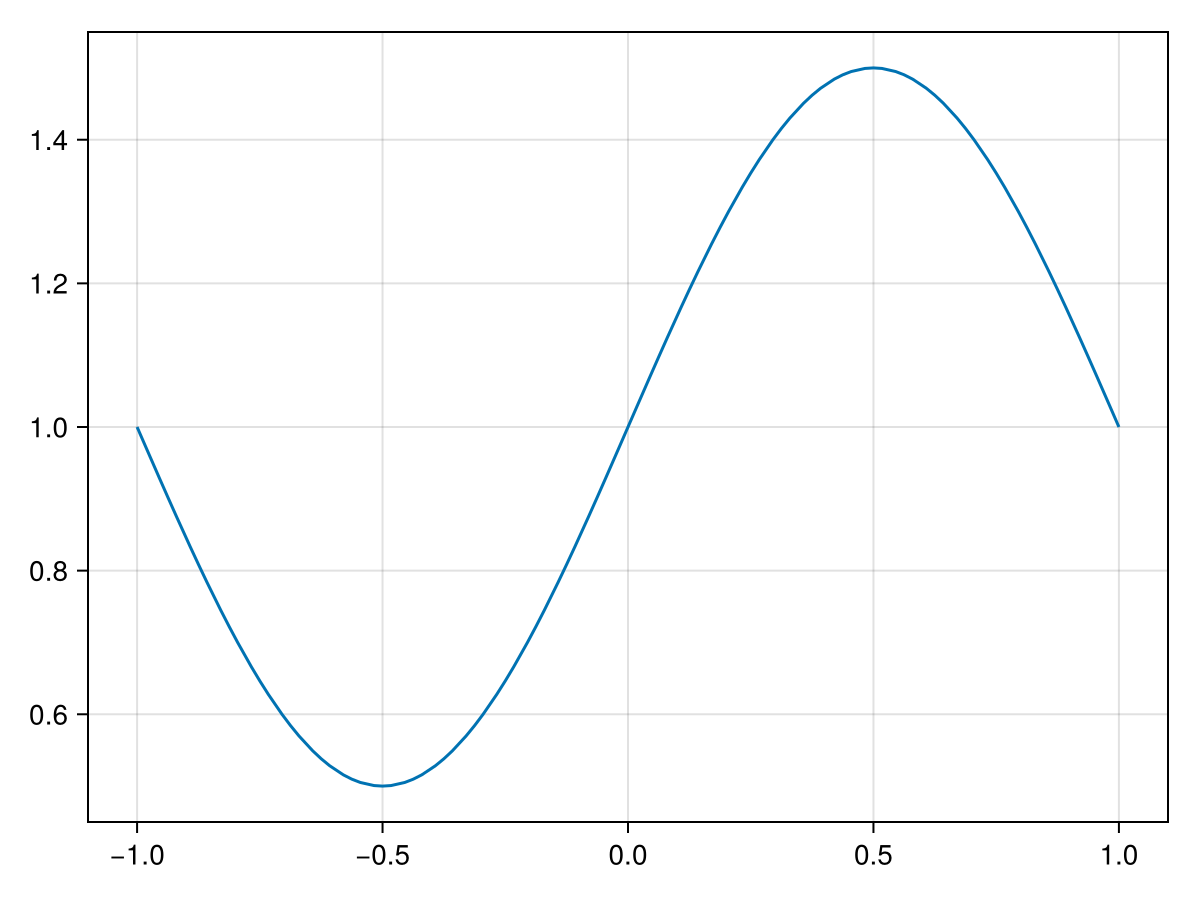

In [4]:
lines(vec(mesh.md.x), map(x-> x[1], vec(sol(1.0))))

In [5]:
nodes, weights = gausslegendre(256)

([-0.9999560500189922, -0.9997684374092631, -0.9994309374662614, -0.9989435258434088, -0.9983062664730065, -0.9975192527567208, -0.9965826020233816, -0.9954964544810964, -0.9942609729224097, -0.9928763426088221  …  0.9928763426088221, 0.9942609729224097, 0.9954964544810964, 0.9965826020233816, 0.9975192527567208, 0.9983062664730065, 0.9989435258434088, 0.9994309374662614, 0.9997684374092631, 0.9999560500189922], [0.00011278901782227218, 0.0002625349442964458, 0.0004124632544261763, 0.0005623489540314098, 0.0007121541634733206, 0.000861853701420089, 0.0010114243932084403, 0.0011608435575677246, 0.0013100886819025041, 0.0014591373333107329  …  0.0014591373333107329, 0.0013100886819025041, 0.0011608435575677246, 0.0010114243932084403, 0.000861853701420089, 0.0007121541634733206, 0.0005623489540314098, 0.0004124632544261763, 0.0002625349442964458, 0.00011278901782227218])

In [6]:
PolyAnnil(collect(0:4)./4,2; Nvar = 2, istruncated = true).P[1:3, 1:5]*randn(5)

3-element Vector{Float64}:
 -1.3455842387856527
  0.5919414448602942
 -0.6990576314988503

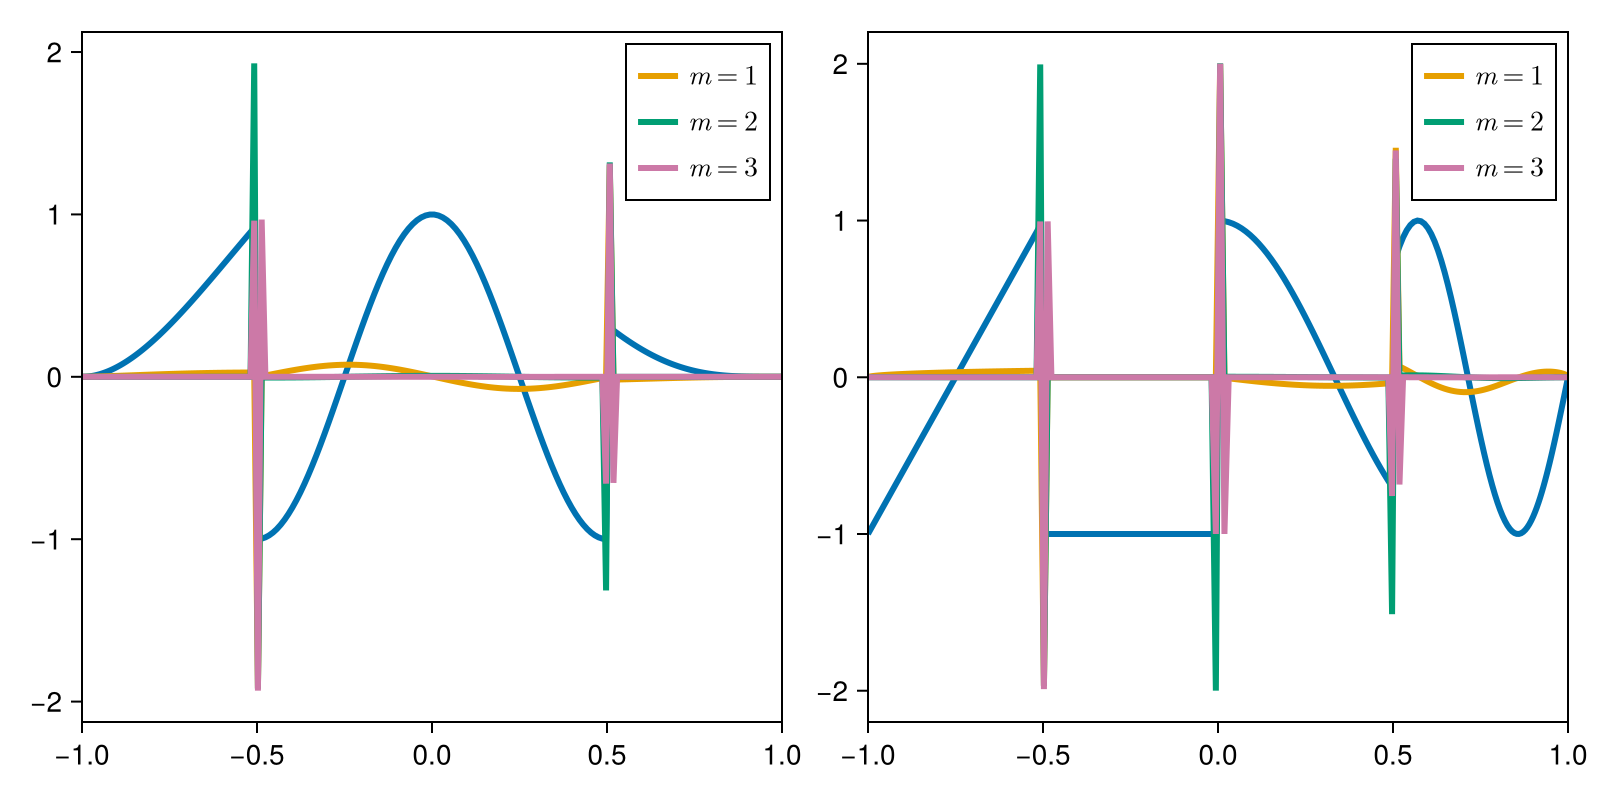

In [7]:
fig = Figure(size = (800, 400))

ax1 = Axis(fig[1,1], xgridvisible = false, ygridvisible = false)

lines!(ax1, nodes, glaubitz_jump1.(nodes), linewidth = 3)
for mi = 1:3
    lines!(ax1, nodes, PolyAnnil(nodes,mi)*glaubitz_jump1.(nodes), linewidth = 3, 
    label = latexstring("m = $mi"))
end
xlims!(ax1, -1, 1)
axislegend(ax1)
        
ax2 = Axis(fig[1,2], xgridvisible = false, ygridvisible = false)

lines!(ax2, nodes, glaubitz_jump2.(nodes), linewidth = 3)
for mi = 1:3
    lines!(ax2, nodes, PolyAnnil(nodes,mi)*glaubitz_jump2.(nodes), linewidth = 3, 
    label = latexstring("m = $mi"))
end

axislegend(ax2)
xlims!(ax2, -1, 1)

    

fig

# latexstring("M = $Nei")

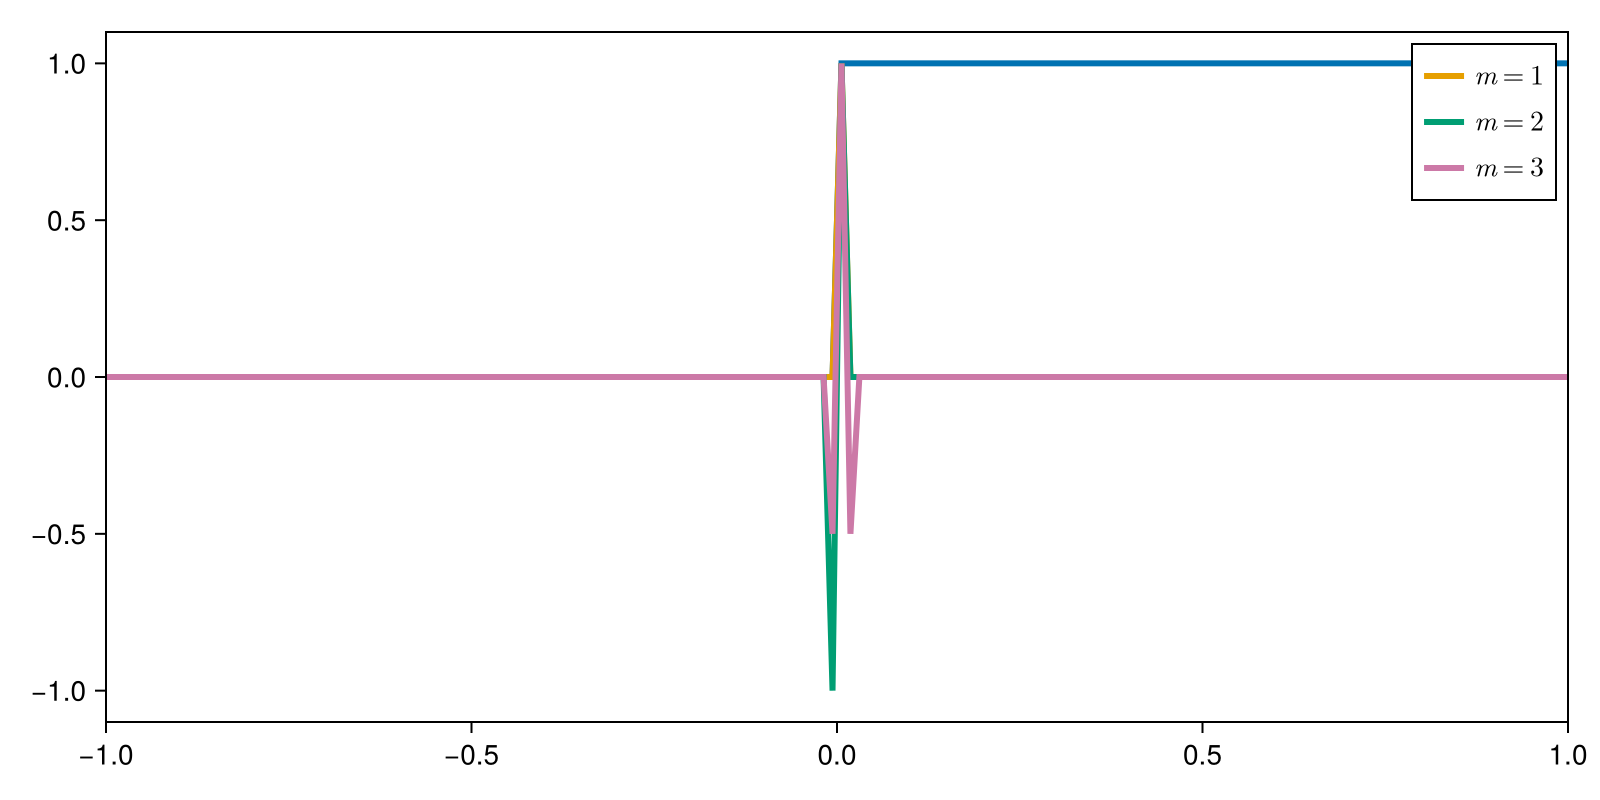

In [10]:
fig = Figure(size = (800, 400))

ax1 = Axis(fig[1,1], xgridvisible = false, ygridvisible = false)

lines!(ax1, nodes, step_function.(nodes), linewidth = 3)
for mi = 1:3
    lines!(ax1, nodes, PolyAnnil(nodes,mi)*step_function.(nodes), linewidth = 3, 
    label = latexstring("m = $mi"))
end
xlims!(ax1, -1, 1)
axislegend(ax1)
        


    

fig

# latexstring("M = $Nei")

In [8]:
fig = Figure(size = ())


for mi = 1:3
    axi = Axis(fig[1,mi])
    lines!(axi, nodes, step_function.(nodes), linewidth = 3)
    lines!(axi, nodes, PolyAnnil(nodes,mi)*step_function.(nodes), linewidth = 3, 
    label = latexstring("m = $mi"))
    axislegend(axi)
end

fig

LoadError: MethodError: no method matching (Recti)(::Int64, ::Int64, ::Tuple{})

[0mClosest candidates are:
[0m  (GeometryBasics.HyperRectangle{N, T} where N)(::Number, ::Number, [91m::Number[39m, [91m::Number[39m) where T
[0m[90m   @[39m [36mGeometryBasics[39m [90m~/.julia/packages/GeometryBasics/ebXl0/src/primitives/[39m[90m[4mrectangles.jl:126[24m[39m
[0m  (GeometryBasics.HyperRectangle{N, T} where N)(::Number, ::Number, [91m::Union{Tuple{T, T}, StaticArraysCore.StaticArray{Tuple{2}, T, 1}} where T[39m) where T
[0m[90m   @[39m [36mGeometryBasics[39m [90m~/.julia/packages/GeometryBasics/ebXl0/src/primitives/[39m[90m[4mrectangles.jl:159[24m[39m
[0m  (GeometryBasics.HyperRectangle{N, T} where N)([91m::Union{Tuple{T, T}, StaticArraysCore.StaticArray{Tuple{2}, T, 1}} where T[39m, ::Number, [91m::Number[39m) where T
[0m[90m   @[39m [36mGeometryBasics[39m [90m~/.julia/packages/GeometryBasics/ebXl0/src/primitives/[39m[90m[4mrectangles.jl:155[24m[39m


In [9]:
function e3(i)
    out = zero(nodes)
    out[i]= 1 
    return out
end

e3 (generic function with 1 method)

In [10]:
PolyAnnil(nodes,2)*e3(3)#(sin.(nodes))

256-element Vector{Float64}:
  0.0
 -0.5558893078928954
  1.6924331041317062
 -1.0000000000000002
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [11]:
@time PA = PolyAnnil(vec(mesh.md.xq),1)#, PeriodicEuclidean(2.0); isperiodic = true)

  0.000064 seconds (266 allocations: 280.750 KiB)


PolyAnnil([-0.9956605097373139, -0.979374407612027, -0.9581255923879736, -0.941839490262686, -0.9331605097373139, -0.9168744076120269, -0.8956255923879736, -0.879339490262686, -0.8706605097373139, -0.8543744076120269  …  0.8543744076120272, 0.8706605097373142, 0.8793394902626858, 0.8956255923879735, 0.9168744076120272, 0.9331605097373142, 0.9418394902626858, 0.9581255923879736, 0.9793744076120273, 0.9956605097373142], 1, sparse([2, 2, 3, 3, 4, 4, 5, 5, 6, 6  …  123, 123, 124, 124, 125, 125, 126, 126, 127, 127], [1, 2, 2, 3, 3, 4, 4, 5, 5, 6  …  122, 123, 123, 124, 124, 125, 125, 126, 126, 127], [-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0  …  -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0], 128, 128))

In [12]:
PA[50,:]

LoadError: MethodError: no method matching getindex(::PolyAnnil, ::Int64, ::Colon)

In [13]:
PA[20,:]

LoadError: MethodError: no method matching getindex(::PolyAnnil, ::Int64, ::Colon)

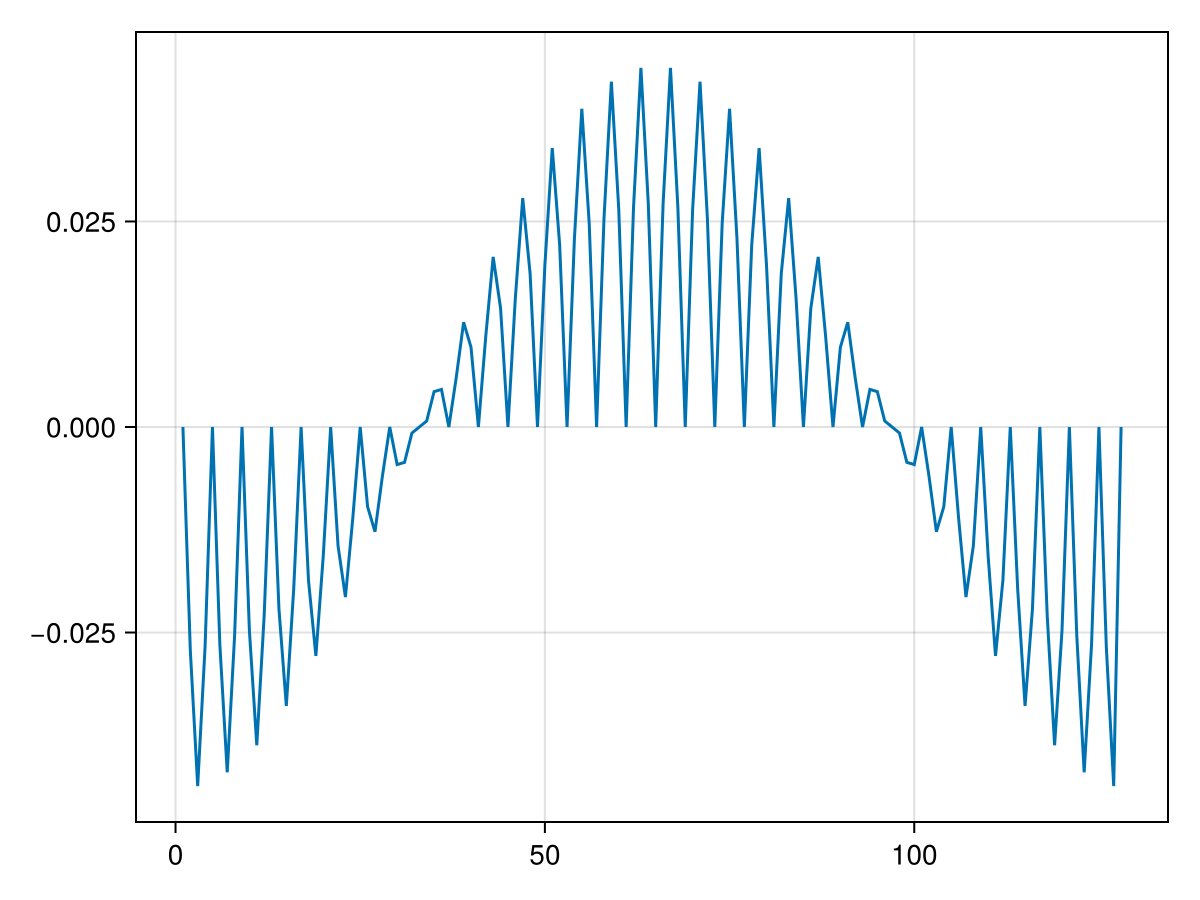

In [14]:
lines(Vector(vcat(PA*vec(sol(1.0)) ...)))

In [15]:
vec(sol(1.0))

128-element StructArray(::Vector{Float64}) with eltype SVector{1, Float64}:
 [1.0000000572598786]
 [0.9728784473676748]
 [0.9291988312685886]
 [0.9024548556270257]
 [0.9024550238851283]
 [0.8759979928804018]
 [0.8339969988657265]
 [0.8086583433732754]
 [0.8086585892386186]
 [0.7838828659856083]
 [0.7451745687009005]
 [0.7222149836780534]
 [0.7222152977021687]
 ⋮
 [1.2777847975175345]
 [1.2548255069444159]
 [1.2161170224155047]
 [1.1913416068759648]
 [1.1913415165638472]
 [1.1660030392805285]
 [1.1240019299614414]
 [1.0975450915578493]
 [1.097545088434169]
 [1.0708011679126686]
 [1.027121512880044]
 [0.9999999730750808]

In [16]:
struct IntervalMapping
    a::Float64
    b::Float64
end

(L::IntervalMapping)(x) = 2*(x-L.a)*inv(L.b-L.a) - 1.0

L = IntervalMapping(0, 1)
@assert L(0) == -1
@assert L(1) == 1

In [13]:
L = IntervalMapping(-1, -1 + 0.0625)

IntervalMapping(-1.0, -0.9375)

In [14]:
@assert isapprox(L.(mesh.md.xq[:,1]), gausslegendre(4)[1], atol = 1e-8)

In [17]:
Pj = fromroots(FactoredPolynomial, nodes)

FactoredPolynomial((x - 0.3399810435848563) * (x + 0.8611363115940526) * (x - 0.8611363115940526) * (x + 0.3399810435848563))

In [18]:
fieldnames(typeof(Pj.coeffs))

(:slots, :keys, :vals, :ndel, :count, :age, :idxfloor, :maxprobe)

In [19]:
Pj.coeffs

Dict{Float64, Int64} with 4 entries:
  0.339981  => 1
  -0.861136 => 1
  0.861136  => 1
  -0.339981 => 1

In [20]:
prod(ifelse(k !=2, k, 1) for k in 1:4)

12

In [21]:
typeof(Pj)

FactoredPolynomial{Float64, :x}

In [22]:
for (i, xi) in enumerate(Pj.coeffs)
    @show i, xi
    @show xi[1]
end

(i, xi) = (1, 0.3399810435848563 => 1)
xi[1] = 0.3399810435848563
(i, xi) = (2, -0.8611363115940526 => 1)
xi[1] = -0.8611363115940526
(i, xi) = (3, 0.8611363115940526 => 1)
xi[1] = 0.8611363115940526
(i, xi) = (4, -0.3399810435848563 => 1)
xi[1] = -0.3399810435848563


In [71]:
# Evaluate the polynomial p at x discarding the jth factor
function evalpoly(x, p::FactoredPolynomial, j::Int64)
    iszero(length(p.coeffs)) && return p.c * one(x)
    out = p.c*one(x)
    @show out
    for (i, kvi) in enumerate(p.coeffs)
        @show i, kvi[1], out
        if i !=j 
            out *= (x-kvi[1])^kvi[2] 
        end
    end
    return out
end

function evalpoly(x::Array, p::FactoredPolynomial, j::Int64)
    iszero(length(p.coeffs)) && return p.c * one(x)
    out = p.c*one(x)
    @show out
    for (i, kvi) in enumerate(p.coeffs)
        @show i, kvi, out
        if i !=j 
            out *= (x-kvi[1])^kvi[2] 
        end
    end
    return out
end

evalpoly (generic function with 2 methods)

In [75]:
nodes[2:end] - nodes[1:end-1]

3-element Vector{Float64}:
 0.5211552680091962
 0.6799620871697126
 0.5211552680091962

In [78]:
nodes

4-element Vector{Float64}:
 -0.8611363115940526
 -0.3399810435848563
  0.3399810435848563
  0.8611363115940526

In [80]:
sort(collect(Pj.coeffs), by = x->x[1])

4-element Vector{Pair{Float64, Int64}}:
 -0.8611363115940526 => 1
 -0.3399810435848563 => 1
  0.3399810435848563 => 1
  0.8611363115940526 => 1

In [ ]:
 lagrange_polynomial(x, i, points) = prod((x-points[k])/(points[i] - points[k]) for k in eachindex(points) if k ≠ i)

In [81]:
lagrange_weights(x, i) = prod(x[i] - x[k] for k in eachindex(x) if k ≠ i)

lagrange_weights (generic function with 1 method)

In [89]:
lagrange_weights(nodes, 4)

1.0780886467356803

In [83]:
(nodes[1]-nodes[2])*(nodes[1]-nodes[3])*(nodes[1]-nodes[4])

-1.07808864673568

In [73]:
Pj = fromroots(FactoredPolynomial, nodes)

FactoredPolynomial((x - 0.3399810435848563) * (x + 0.8611363115940526) * (x - 0.8611363115940526) * (x + 0.3399810435848563))

In [ ]:
(nodes[1] - nodes[1])*(nodes[2])

In [74]:
evalpoly(nodes[1], Pj, 1)

out = 1.0
(i, kvi[1], out) = (1, 0.3399810435848563, 1.0)
(i, kvi[1], out) = (2, -0.8611363115940526, 1.0)
(i, kvi[1], out) = (3, 0.8611363115940526, 0.0)
(i, kvi[1], out) = (4, -0.3399810435848563, -0.0)


0.0

In [90]:
struct Lagrange
    x::Vector{Float64}
    P::FactoredPolynomial{Float64, :x}
    ω::Vector{Float64}
end

In [96]:
function Lagrange(x::Vector{Float64})
    P = fromroots(FactoredPolynomial, x)
    ω = zero(x)
    
    for (i, xi) in enumerate(x)
        ω[i] = prod(xi - x[k] for k in eachindex(x) if k ≠ i)
    end
    return Lagrange(x, P, ω)
end

Lagrange

In [ ]:
struct PolyAnnil
    P
    
    
end

In [134]:
PA = PolyAnnil(nodes, 5)

LoadError: UndefVarError: `idx` not defined

In [113]:
evaluate(PeriodicEuclidean(1.0), 0.0, 1.0)

0.0

In [119]:
typeof(PeriodicEuclidean(1.0))<:Distances.UnionMetric

true

In [121]:
?neighbors#(nodes)

search: neighbors NearestNeighbors



```
neighbors(g, v)
```

Return a list of all neighbors reachable from vertex `v` in `g`. For directed graphs, the default is equivalent to [`outneighbors`](@ref); use [`all_neighbors`](@ref) to list inbound and outbound neighbors.

### Implementation Notes

Returns a reference to the current graph's internal structures, not a copy. Do not modify result. If the graph is modified, the behavior is undefined: the array behind this reference may be modified too, but this is not guaranteed.

# Examples

```jldoctest
julia> using Graphs

julia> g = DiGraph(3);

julia> add_edge!(g, 2, 3);

julia> add_edge!(g, 3, 1);

julia> neighbors(g, 1)
Int64[]

julia> neighbors(g, 2)
1-element Vector{Int64}:
 3

julia> neighbors(g, 3)
1-element Vector{Int64}:
 1
```

---

```
neighbors(grid, site)
```

return an iterator over neighbors of site in ascending order. Do not use in hot loops


In [102]:
Lagrange(nodes)

Lagrange([-0.9931285991850949, -0.9639719272779138, -0.912234428251326, -0.8391169718222188, -0.7463319064601508, -0.636053680726515, -0.5108670019508271, -0.37370608871541955, -0.2277858511416451, -0.07652652113349732, 0.07652652113349732, 0.2277858511416451, 0.37370608871541955, 0.5108670019508271, 0.636053680726515, 0.7463319064601508, 0.8391169718222188, 0.912234428251326, 0.9639719272779138, 0.9931285991850949], FactoredPolynomial((x - 0.37370608871541955) * (x + 0.912234428251326) * (x - 0.636053680726515) * (x + 0.07652652113349732) * (x + 0.8391169718222188) * (x + 0.37370608871541955) * (x + 0.7463319064601508) * (x + 0.2277858511416451) * (x - 0.5108670019508271) * (x - 0.9931285991850949) * (x - 0.7463319064601508) * (x + 0.5108670019508271) * (x - 0.8391169718222188) * (x + 0.9639719272779138) * (x - 0.2277858511416451) * (x - 0.912234428251326) * (x + 0.636053680726515) * (x - 0.07652652113349732) * (x + 0.9931285991850949) * (x - 0.9639719272779138)), [-0.0006926274370269